In [1]:
import numpy as np
import matplotlib.pyplot as pt
import scipy as ci
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

<font size=5> Problem 1<font>


Now instantiating the solar system.
planetary configuration for U.S. Central Time  Sun Apr  3 19:00:00 2016
Probe landed: end loop at elapsed time  894057.5  seconds =  10.347887731481482  days


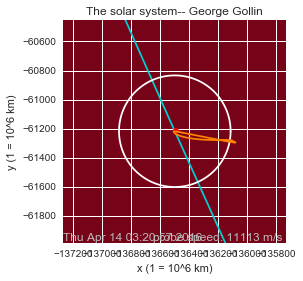

In [2]:
############# Altering step size dt by dt/2 if delta is too large,
# and dt*2 if the step is too small. Only after three iterations 
# should we alter dt, and the minimum length of v stored is 2, 
# so (index+1)%3 should be 0. 
import week06_solarsystemObject as SSO
import numpy as np
Vx=[]
Vy=[]
T=[]
D=[]
DT=[]
############# initialize stuff #############
# Let's launch a space probe from low earth orbit intended to arrive at (or
# at least pass near) the moon.
# Our coordinate system is heliocentric: the sun is at the origin. I pretend
# that all planets orbit in perfect circles in the same plane. The x and y
# axes are defined with respect to the fixed stars. This means that we will need
# to translate positions and velocities with respect to earth into quantities
# with respect to the sun.
   
# At my reference time t = 0 (April 1, 2016 00:00:00 GMT) the earth was a little
# bit on the negative y side of the negative x axis.
# instantiate the solar system!
MySolarSystem = SSO.SolarSystem()
# Let's launch our probe from orbit at a starting time (in seconds) of 0. This
# will be the "knob" we will adjust since t = 0 and the parameters set below 
# will put the space probe ahead of the moon as it crosses the lunar orbit.
start_time = 86400*3
# here's how you figure out where the planets are at a particular instant of 
# time. xplanet_all and yplanet_all are arrays.
xplanet_all, yplanet_all = MySolarSystem.get_planet_xy(start_time)
# the x,y positions for the earth are stored in the 4th elements in the arrays
xearth_now = xplanet_all[MySolarSystem.earth_index]
yearth_now = yplanet_all[MySolarSystem.earth_index]
# you can get the planets' velocities (in our heliocentric frame) the same way.
# note the presence of the current time in the function call. 
vxplanet_all, vyplanet_all = MySolarSystem.get_planet_vxvy(start_time)
# x,y velocities for the earth right now are the 4th elements in the arrays. 
vxearth_now = vxplanet_all[MySolarSystem.earth_index]
vyearth_now = vyplanet_all[MySolarSystem.earth_index]
# TLI is "Trans Lunar Injection." Apollo 11 left earth orbit with an initial speed 
# of 35,570 feet per second (10,841.736 m/s) and an altitude of 177 nautical miles
# (203.688 statute miles, or 327,804.157 meters). 
# see http://history.nasa.gov/ap11fj/02earth-orbit-tli.htm.
TLI_v0 = 10841.736
TLI_altitude = 327804.157
# angle for probe initial position relative to the earth and +x direction
# when the TLI burn takes place. I picked this because it does what I want. 
TLI_theta = 180. * np.pi / 180.
# We will need to transform the earth-centric position and velocity to a 
# heliocentric frame of reference. First convert TLI_altitude to distance from 
# the center of the earth. Note how I picked the earth radius out of the array 
# of planet radii.
TLI_r0 = TLI_altitude + MySolarSystem.planet_radius[MySolarSystem.earth_index]
# use this to calculate x, y offsets for probe from earth's center, then add
# into it the earth's position relative to the sun.
TLI_x0 = TLI_r0 * np.cos(TLI_theta) + xearth_now
TLI_y0 = TLI_r0 * np.sin(TLI_theta) + yearth_now
# also get the x, y velocity components in a helio-centric coordinate system.
# (FYI: the earth orbits in a counterclockwise direction when seen from a vantage
# point on the positive z axis.)
TLI_vx0 = -TLI_v0 * np.sin(TLI_theta) + vxearth_now
TLI_vy0 = TLI_v0 * np.cos(TLI_theta) + vyearth_now
# now initialize the probe's position. 
xprobe_now = TLI_x0
yprobe_now = TLI_y0
# set the initial velocity (m/s) too.
vxprobe_now = TLI_vx0
vyprobe_now = TLI_vy0
# time interval between steps in our numerical integration, in seconds. 
TLI_dt = 10
# dt for use inside our loop:
dt = TLI_dt
# current time
time_now = start_time
# maximum total length in days of our space flight
max_days_in_flight = 15
# also calculate the maximum time in seconds.
max_elapsed_time_in_flight = max_days_in_flight * 24 * 3600
# we might not start at start_time = 0, which is April 1, 2016. Take this into
# account here. Time is in seconds.
flight_must_end_by_this_time = max_elapsed_time_in_flight + start_time
# number of steps to calculate: one more step than a specific number of days of
# simulated flight.
max_steps_float = max_days_in_flight * 24 * 60 * (60 / TLI_dt) + 1 
# now turn this into an integer. round up using the ceil ("ceiling") function.
max_steps = int(np.ceil(max_steps_float))
# preallocate storage for arrays we will use; initilize them to "not a number" 
# (nan). this should save time over doing an append each time we want to add an 
# element into the array.
# xprobe, yprobe is probe position with respect to the sun.
xprobe = np.array([np.nan] * max_steps)
yprobe = np.array([np.nan] * max_steps)
# now create arrays of x, y points for the earth, also filled with "nan." 
xearth = np.array([np.nan] * max_steps)
yearth = np.array([np.nan] * max_steps)
# let's keep track of the probe's velocity with respect to the sun too.
vxprobe = np.array([np.nan] * max_steps)
vyprobe = np.array([np.nan] * max_steps)
# in a later week we will try using dt's that can vary with circumstances so
# add a couple more arrays to help with this.
tprobe = np.array([np.nan] * max_steps)
dtprobe = np.array([np.nan] * max_steps)
# we don't want to draw an image of where the probe is every pass through the 
# loop since that would slow us down too much. Let's limit the number of images 
# here.
max_images = 50
steps_per_image = np.ceil(max_steps_float / max_images)
      
# loop index variable
index = 0
# we don't want to have a zillion figure windows open, so set the following flag
# to  True.
close_previous_figure = True
# do we want to stop the loop when we land (or crash) into a planet? If not,
# the loop will pretend that all planets are point masses.
stop_when_probe_lands = True
############# here's the loop #############
while (index < max_steps) and (time_now <= flight_must_end_by_this_time):
    
    # insert current position into the existing probe position arrays.
    xprobe[index] = xprobe_now
    yprobe[index] = yprobe_now
    
    # do the same for the probe's velocity.
    vxprobe[index] = vxprobe_now
    vyprobe[index] = vyprobe_now
    # also store time and dt in arrays.
    tprobe[index] = time_now
    dtprobe[index] = dt
    # do the same for the earth's position.
    xearth[index] = xearth_now
    yearth[index] = yearth_now 
    
    
    ################################### Appending velocity to list
    Vx.append(vxprobe_now)
    Vy.append(vyprobe_now)
    T.append(time_now)
    
    if len(Vx)>=3:
        if (index+1)%3==0:
            Delta=np.sqrt(((Vx[index]-2*Vx[index-1]+Vx[index-2])*dt)**2+((Vy[index]-2*Vy[index-1]+Vy[index-2])*dt)**2)
            if Delta>0.1:
                dt=dt/2
            if Delta<0.001:
                dt=dt*2
            DT.append(dt)
            D.append(Delta)
        else:
            Delta=np.sqrt(((Vx[index]-2*Vx[index-1]+Vx[index-2])*dt)**2+((Vy[index]-2*Vy[index-1]+Vy[index-2])*dt)**2)
            DT.append(dt)
            D.append(Delta)
    ################################### Edited above
    
    
    # let's keep track of whether or not the probe has crashed into the surface
    # of something. The value returned by the class function call will be 
    # negative if we haven't hit anything. If non-negative it is the index 
    # number of what we hit. 0 is the sun, 1 is Mercury, 2 is Venus, 3 is Earth, 
    # etc. The moon is 10.      
    the_probe_has_landed = MySolarSystem.crash_landing(time_now, xprobe_now, \
    yprobe_now)    
    
    # do I want to draw the solar system? draw it when the modulus of index 
    # and steps_per_image is zero. 
    draw_the_solar_system = (index % steps_per_image == 0)
    
    # If we decide to break out of the loop when we land, rather than continuing
    # to loop, we might draw the solar system one last time. But only enable
    # this code if you are going to exit the loop, otherwise you'll draw a zillion
    # plots, one for each pass through the loop after a landing.
    draw_the_solar_system = draw_the_solar_system or \
    (the_probe_has_landed >= 0 and stop_when_probe_lands)
    
    # now draw it if we want to.
    if draw_the_solar_system:
        # figure out the probe's speed so we can put this number on the plot.
        # calculate it both with respect to the earth (useful for a moon shot)
        # and with respect to the sun (useful for a Mars shot).
        # get the earth's with respect to the x,y velocity for the earth right now:
        vxplanet_all, vyplanet_all = MySolarSystem.get_planet_vxvy(time_now)
        vxearth_now = vxplanet_all[MySolarSystem.earth_index]
        vyearth_now = vyplanet_all[MySolarSystem.earth_index]
        # now calculate the probe's speed with respect to the sun.
        speed_wrt_sun = np.sqrt(vxprobe_now**2 + vyprobe_now**2)   
        # now calculate the probe's speed with respect to the earth.
        speed_wrt_earth = np.sqrt((vxprobe_now - vxearth_now)**2 + \
        (vyprobe_now - vyearth_now)**2)   
        # calculate probe positions arrays referenced to the current earth position.
        # note that xprobe and xearth are arrays, but xearth_now is just a number.
        xprobe_wrt_moving_earth = xprobe - xearth + xearth_now
        yprobe_wrt_moving_earth = yprobe - yearth + yearth_now
        # the following uses the earth as the origin in showing the probe.
        # use it for a moon shot.
        MySolarSystem.draw_earth_centric(time_now, close_previous_figure, \
        xprobe_wrt_moving_earth, yprobe_wrt_moving_earth, speed_wrt_earth)
        # this drawing function plots a larger portion of the solar system.
        # MySolarSystem.draw_solar_system(time_now, close_previous_figure, xprobe, \
        # yprobe, speed_wrt_sun)
    # break out of the loop if the probe just landed and we don't want to 
    # continue adjusting pisition and velocity.
    if the_probe_has_landed >= 0 and stop_when_probe_lands:
        print("Probe landed: end loop at elapsed time ", time_now - start_time, \
        " seconds = ", (time_now - start_time)/(24*3600), " days" )
        break
    
    # now update probe position and velocity using the higher order integration
    # technique from last week. use the same variable names as last week to
    # avoid errors and confusion.
    
    # position components
    xn = xprobe_now
    yn = yprobe_now
    # velocity components...
    vxn = vxprobe_now
    vyn = vyprobe_now
    
    # time
    tn = time_now
    
    # calculate dxn, etc. Note the call to a class function that gives us
    # gravitational acceleration as a function of position with resect to the sun.
    dxn = vxn * dt
    dyn = vyn * dt
    dvxn, dvyn = MySolarSystem.accel(xn, yn, tn) * dt
    # update intermediate position, velocity, and time
    xn_half = xn + dxn / 2
    yn_half = yn + dyn / 2
    vxn_half = vxn + dvxn / 2
    vyn_half = vyn + dvyn / 2
    tn_half = tn + dt / 2
    # calculate improved dxn, etc. see the in-class material writeup.
    dxn_improved = vxn_half * dt
    dyn_improved = vyn_half * dt
    dvxn_improved, dvyn_improved = MySolarSystem.accel(xn_half, yn_half, tn_half) * dt
    # now update position and velocity.
    xn = xn + dxn_improved
    yn = yn + dyn_improved
    vxn = vxn + dvxn_improved
    vyn = vyn + dvyn_improved
    # time too...
    tn = tn + dt
    # now put this back into the variables I am using elsewhere...
    xprobe_now = xn
    yprobe_now = yn
    vxprobe_now = vxn
    vyprobe_now = vyn
    time_now = tn
    # update the x,y position for the earth right now:
    xplanet_all, yplanet_all = MySolarSystem.get_planet_xy(time_now)
    xearth_now = xplanet_all[MySolarSystem.earth_index]
    yearth_now = yplanet_all[MySolarSystem.earth_index]
    # update index 
    index = index + 1
    # end of loop. 
# we have filled various arrays with indices running from 0 to index - 1.
# now truncate them to have full lengths of index. This might be necessary
# if we hit the maximum elapsed time in flight (due to changes in dt) before
# we run out of array space.
xprobe = np.resize(xprobe, index)
yprobe = np.resize(yprobe, index)
vxprobe = np.resize(vxprobe, index)
vyprobe = np.resize(vyprobe, index)
tprobe = np.resize(tprobe, index)
dtprobe = np.resize(dtprobe, index)
xearth = np.resize(xearth, index)
yearth = np.resize(yearth, index)
        
############# all done! #############

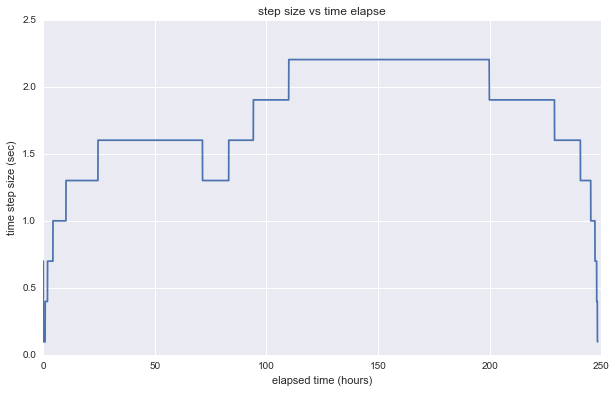

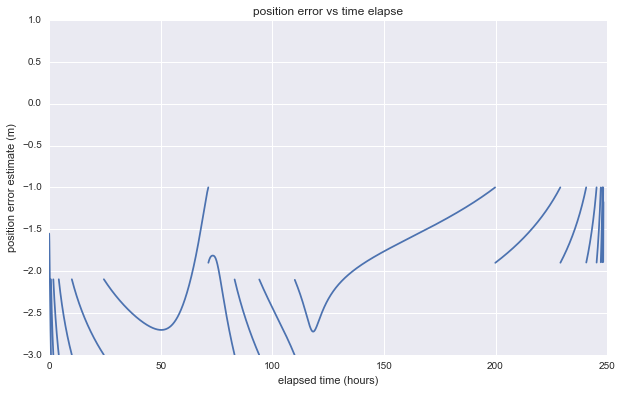

In [3]:
### plotting step/difference vs time. In the second plot, 
### steep slopes are not shown.
pt.figure(figsize=(10,6))
pt.plot((np.asarray(T[2:])-86400*3)/(3600),np.log10(DT))
pt.xlabel('elapsed time (hours)')
pt.ylabel('time step size (sec)')
pt.title('step size vs time elapse')

pt.figure(figsize=(10,6))
y = np.ma.array(np.log10(D))
y_mask = np.ma.masked_where(np.log10(D)>-1 , D)
pt.plot((np.asarray(T[2:])-86400*3)/(3600),np.log10(y_mask))
pt.ylim(-3,1)
pt.xlabel('elapsed time (hours)')
pt.ylabel('position error estimate (m)')
pt.title('position error vs time elapse')
pt.show()


Now instantiating the solar system.
planetary configuration for U.S. Central Time  Sun Apr  3 19:00:00 2016
Probe landed: end loop at elapsed time  891230  seconds =  10.315162037037037  days


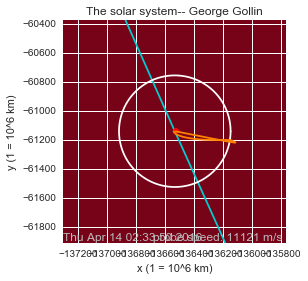

In [4]:
## Just make dt=10 in all conditions
import week06_solarsystemObject as SSO
import numpy as np
Vx=[]
Vy=[]
T=[]
D=[]
DT=[]
############# initialize stuff #############
# Let's launch a space probe from low earth orbit intended to arrive at (or
# at least pass near) the moon.
# Our coordinate system is heliocentric: the sun is at the origin. I pretend
# that all planets orbit in perfect circles in the same plane. The x and y
# axes are defined with respect to the fixed stars. This means that we will need
# to translate positions and velocities with respect to earth into quantities
# with respect to the sun.
   
# At my reference time t = 0 (April 1, 2016 00:00:00 GMT) the earth was a little
# bit on the negative y side of the negative x axis.
# instantiate the solar system!
MySolarSystem = SSO.SolarSystem()
# Let's launch our probe from orbit at a starting time (in seconds) of 0. This
# will be the "knob" we will adjust since t = 0 and the parameters set below 
# will put the space probe ahead of the moon as it crosses the lunar orbit.
start_time = 86400*3
# here's how you figure out where the planets are at a particular instant of 
# time. xplanet_all and yplanet_all are arrays.
xplanet_all, yplanet_all = MySolarSystem.get_planet_xy(start_time)
# the x,y positions for the earth are stored in the 4th elements in the arrays
xearth_now = xplanet_all[MySolarSystem.earth_index]
yearth_now = yplanet_all[MySolarSystem.earth_index]
# you can get the planets' velocities (in our heliocentric frame) the same way.
# note the presence of the current time in the function call. 
vxplanet_all, vyplanet_all = MySolarSystem.get_planet_vxvy(start_time)
# x,y velocities for the earth right now are the 4th elements in the arrays. 
vxearth_now = vxplanet_all[MySolarSystem.earth_index]
vyearth_now = vyplanet_all[MySolarSystem.earth_index]
# TLI is "Trans Lunar Injection." Apollo 11 left earth orbit with an initial speed 
# of 35,570 feet per second (10,841.736 m/s) and an altitude of 177 nautical miles
# (203.688 statute miles, or 327,804.157 meters). 
# see http://history.nasa.gov/ap11fj/02earth-orbit-tli.htm.
TLI_v0 = 10841.736
TLI_altitude = 327804.157
# angle for probe initial position relative to the earth and +x direction
# when the TLI burn takes place. I picked this because it does what I want. 
TLI_theta = 180. * np.pi / 180.
# We will need to transform the earth-centric position and velocity to a 
# heliocentric frame of reference. First convert TLI_altitude to distance from 
# the center of the earth. Note how I picked the earth radius out of the array 
# of planet radii.
TLI_r0 = TLI_altitude + MySolarSystem.planet_radius[MySolarSystem.earth_index]
# use this to calculate x, y offsets for probe from earth's center, then add
# into it the earth's position relative to the sun.
TLI_x0 = TLI_r0 * np.cos(TLI_theta) + xearth_now
TLI_y0 = TLI_r0 * np.sin(TLI_theta) + yearth_now
# also get the x, y velocity components in a helio-centric coordinate system.
# (FYI: the earth orbits in a counterclockwise direction when seen from a vantage
# point on the positive z axis.)
TLI_vx0 = -TLI_v0 * np.sin(TLI_theta) + vxearth_now
TLI_vy0 = TLI_v0 * np.cos(TLI_theta) + vyearth_now
# now initialize the probe's position. 
xprobe_now = TLI_x0
yprobe_now = TLI_y0
# set the initial velocity (m/s) too.
vxprobe_now = TLI_vx0
vyprobe_now = TLI_vy0
# time interval between steps in our numerical integration, in seconds. 
TLI_dt = 10
# dt for use inside our loop:
dt = TLI_dt
# current time
time_now = start_time
# maximum total length in days of our space flight
max_days_in_flight = 15
# also calculate the maximum time in seconds.
max_elapsed_time_in_flight = max_days_in_flight * 24 * 3600
# we might not start at start_time = 0, which is April 1, 2016. Take this into
# account here. Time is in seconds.
flight_must_end_by_this_time = max_elapsed_time_in_flight + start_time
# number of steps to calculate: one more step than a specific number of days of
# simulated flight.
max_steps_float = max_days_in_flight * 24 * 60 * (60 / TLI_dt) + 1 
# now turn this into an integer. round up using the ceil ("ceiling") function.
max_steps = int(np.ceil(max_steps_float))
# preallocate storage for arrays we will use; initilize them to "not a number" 
# (nan). this should save time over doing an append each time we want to add an 
# element into the array.
# xprobe, yprobe is probe position with respect to the sun.
xprobe = np.array([np.nan] * max_steps)
yprobe = np.array([np.nan] * max_steps)
# now create arrays of x, y points for the earth, also filled with "nan." 
xearth = np.array([np.nan] * max_steps)
yearth = np.array([np.nan] * max_steps)
# let's keep track of the probe's velocity with respect to the sun too.
vxprobe = np.array([np.nan] * max_steps)
vyprobe = np.array([np.nan] * max_steps)
# in a later week we will try using dt's that can vary with circumstances so
# add a couple more arrays to help with this.
tprobe = np.array([np.nan] * max_steps)
dtprobe = np.array([np.nan] * max_steps)
# we don't want to draw an image of where the probe is every pass through the 
# loop since that would slow us down too much. Let's limit the number of images 
# here.
max_images = 50
steps_per_image = np.ceil(max_steps_float / max_images)
      
# loop index variable
index = 0
# we don't want to have a zillion figure windows open, so set the following flag
# to  True.
close_previous_figure = True
# do we want to stop the loop when we land (or crash) into a planet? If not,
# the loop will pretend that all planets are point masses.
stop_when_probe_lands = True
############# here's the loop #############
while (index < max_steps) and (time_now <= flight_must_end_by_this_time):
    
    # insert current position into the existing probe position arrays.
    xprobe[index] = xprobe_now
    yprobe[index] = yprobe_now
    
    # do the same for the probe's velocity.
    vxprobe[index] = vxprobe_now
    vyprobe[index] = vyprobe_now
    # also store time and dt in arrays.
    tprobe[index] = time_now
    dtprobe[index] = dt
    # do the same for the earth's position.
    xearth[index] = xearth_now
    yearth[index] = yearth_now 
    
    
    ################################### Appending velocity to list
    Vx.append(vxprobe_now)
    Vy.append(vyprobe_now)
    T.append(time_now)
    
    if len(Vx)>=3:
        if (index+1)%3==0:
            Delta=np.sqrt(((Vx[index]-2*Vx[index-1]+Vx[index-2])*dt)**2+((Vy[index]-2*Vy[index-1]+Vy[index-2])*dt)**2)
            if Delta>0.1:
                dt=10
            if Delta<0.001:
                dt=10
            DT.append(dt)
            D.append(Delta)
        else:
            Delta=np.sqrt(((Vx[index]-2*Vx[index-1]+Vx[index-2])*dt)**2+((Vy[index]-2*Vy[index-1]+Vy[index-2])*dt)**2)
            DT.append(dt)
            D.append(Delta)
    ################################### Edited above
    
    
    # let's keep track of whether or not the probe has crashed into the surface
    # of something. The value returned by the class function call will be 
    # negative if we haven't hit anything. If non-negative it is the index 
    # number of what we hit. 0 is the sun, 1 is Mercury, 2 is Venus, 3 is Earth, 
    # etc. The moon is 10.      
    the_probe_has_landed = MySolarSystem.crash_landing(time_now, xprobe_now, \
    yprobe_now)    
    
    # do I want to draw the solar system? draw it when the modulus of index 
    # and steps_per_image is zero. 
    draw_the_solar_system = (index % steps_per_image == 0)
    
    # If we decide to break out of the loop when we land, rather than continuing
    # to loop, we might draw the solar system one last time. But only enable
    # this code if you are going to exit the loop, otherwise you'll draw a zillion
    # plots, one for each pass through the loop after a landing.
    draw_the_solar_system = draw_the_solar_system or \
    (the_probe_has_landed >= 0 and stop_when_probe_lands)
    
    # now draw it if we want to.
    if draw_the_solar_system:
        
        # figure out the probe's speed so we can put this number on the plot.
        # calculate it both with respect to the earth (useful for a moon shot)
        # and with respect to the sun (useful for a Mars shot).
        # get the earth's with respect to the x,y velocity for the earth right now:
        vxplanet_all, vyplanet_all = MySolarSystem.get_planet_vxvy(time_now)
        vxearth_now = vxplanet_all[MySolarSystem.earth_index]
        vyearth_now = vyplanet_all[MySolarSystem.earth_index]
        # now calculate the probe's speed with respect to the sun.
        speed_wrt_sun = np.sqrt(vxprobe_now**2 + vyprobe_now**2)   
        
        # now calculate the probe's speed with respect to the earth.
        speed_wrt_earth = np.sqrt((vxprobe_now - vxearth_now)**2 + \
        (vyprobe_now - vyearth_now)**2)   
        
        # calculate probe positions arrays referenced to the current earth position.
        # note that xprobe and xearth are arrays, but xearth_now is just a number.
        xprobe_wrt_moving_earth = xprobe - xearth + xearth_now
        yprobe_wrt_moving_earth = yprobe - yearth + yearth_now
        
        # the following uses the earth as the origin in showing the probe.
        # use it for a moon shot.
        MySolarSystem.draw_earth_centric(time_now, close_previous_figure, \
        xprobe_wrt_moving_earth, yprobe_wrt_moving_earth, speed_wrt_earth)
    
        # this drawing function plots a larger portion of the solar system.
        # MySolarSystem.draw_solar_system(time_now, close_previous_figure, xprobe, \
        # yprobe, speed_wrt_sun)
    
    # break out of the loop if the probe just landed and we don't want to 
    # continue adjusting pisition and velocity.
    if the_probe_has_landed >= 0 and stop_when_probe_lands:
        print("Probe landed: end loop at elapsed time ", time_now - start_time, \
        " seconds = ", (time_now - start_time)/(24*3600), " days" )
        break
    
    # now update probe position and velocity using the higher order integration
    # technique from last week. use the same variable names as last week to
    # avoid errors and confusion.
    
    # position components
    xn = xprobe_now
    yn = yprobe_now
    # velocity components...
    vxn = vxprobe_now
    vyn = vyprobe_now
    
    # time
    tn = time_now
    
    # calculate dxn, etc. Note the call to a class function that gives us
    # gravitational acceleration as a function of position with resect to the sun.
    dxn = vxn * dt
    dyn = vyn * dt
    dvxn, dvyn = MySolarSystem.accel(xn, yn, tn) * dt
    
    # update intermediate position, velocity, and time
    xn_half = xn + dxn / 2
    yn_half = yn + dyn / 2
    vxn_half = vxn + dvxn / 2
    vyn_half = vyn + dvyn / 2
    tn_half = tn + dt / 2
    
    # calculate improved dxn, etc. see the in-class material writeup.
    dxn_improved = vxn_half * dt
    dyn_improved = vyn_half * dt
    dvxn_improved, dvyn_improved = MySolarSystem.accel(xn_half, yn_half, tn_half) * dt
    
    # now update position and velocity.
    xn = xn + dxn_improved
    yn = yn + dyn_improved
    vxn = vxn + dvxn_improved
    vyn = vyn + dvyn_improved
    
    # time too...
    tn = tn + dt
    
    # now put this back into the variables I am using elsewhere...
    
    xprobe_now = xn
    yprobe_now = yn
    vxprobe_now = vxn
    vyprobe_now = vyn
    time_now = tn
    
    # update the x,y position for the earth right now:
    xplanet_all, yplanet_all = MySolarSystem.get_planet_xy(time_now)
    xearth_now = xplanet_all[MySolarSystem.earth_index]
    yearth_now = yplanet_all[MySolarSystem.earth_index]
    
    # update index 
    index = index + 1
    # end of loop. 
# we have filled various arrays with indices running from 0 to index - 1.
# now truncate them to have full lengths of index. This might be necessary
# if we hit the maximum elapsed time in flight (due to changes in dt) before
# we run out of array space.
xprobe = np.resize(xprobe, index)
yprobe = np.resize(yprobe, index)
vxprobe = np.resize(vxprobe, index)
vyprobe = np.resize(vyprobe, index)
tprobe = np.resize(tprobe, index)
dtprobe = np.resize(dtprobe, index)
xearth = np.resize(xearth, index)
yearth = np.resize(yearth, index)
        
############# all done! #############

(-7, 6)

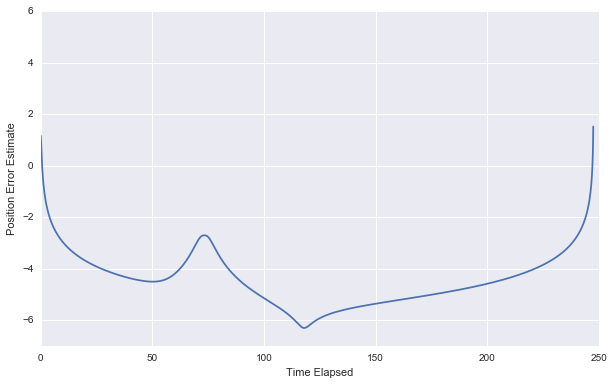

In [7]:
pt.figure(figsize=(10,6))
pt.plot(np.asarray(T[2:]-np.ones(len(DT))*86400*3)/(3600),np.log10(D),'-')
pt.xlabel('Time Elapsed')
pt.ylabel('Position Error Estimate')
pt.ylim(-7,6)

<font size=5> Problem 2<font>


In [57]:
## keep changing "speed" until the track looks that on lecture notes.
def F(speed):
    ###################################################################
    # This file is week07_voyager_2.py. It simulates the Voyager 2 trajectory
    # past the orbit of Uranus. (It is an imperfect match to the real mission's
    # trajectory!)
    # distances are in meters, and times in seconds.
    # George Gollin, University of Illinois, June 16, 2016
    # import libraries
    import week06_solarsystemObject as SSO
    import numpy as np
    import matplotlib.pyplot as plt 
    ############# initialize stuff #############
    # Let's launch a space probe from low earth orbit intended to head to the outer
    # planets
    # Our coordinate system is heliocentric: the sun is at the origin. I pretend
    # that all planets orbit in perfect circles in the same plane. The x and y
    # axes are defined with respect to the fixed stars. This means that we will need
    # to translate positions and velocities with respect to earth into quantities
    # with respect to the sun.
    # instantiate the solar system!
    MySolarSystem = SSO.SolarSystem()
    # At my reference time t = 0 (April 1, 2016 00:00:00Z where "Z" means Greenwich
    # Mean Time), the earth was a little bit on the negative y side of the negative 
    # x axis. But let's launch Voyager 2 on its actuall launch date of August 20,
    # 1977. Let's call the time it left earth orbit 16:00:00Z.
    start_time = -1218510000
    # here's how you figure out where the planets are at a particular instant of 
    # time. xplanet_all and yplanet_all are arrays.
    xplanet_all, yplanet_all = MySolarSystem.get_planet_xy(start_time)
    # the x,y positions for the earth are stored in the 4th elements in the arrays
    xearth_now = xplanet_all[MySolarSystem.earth_index]
    yearth_now = yplanet_all[MySolarSystem.earth_index]
    # you can get the planets' velocities (in our heliocentric frame) the same way.
    # note the presence of the current time in the function call. 
    vxplanet_all, vyplanet_all = MySolarSystem.get_planet_vxvy(start_time)
    # x,y velocities for the earth right now are the 4th elements in the arrays. 
    vxearth_now = vxplanet_all[MySolarSystem.earth_index]
    vyearth_now = vyplanet_all[MySolarSystem.earth_index]
    # set the width of the plot to be fairly large.
    MySolarSystem.plotwidth_mega_km = 2.1 * MySolarSystem.orbit_radius_neptune / 1.e9
    # TNI is "Trans Neptune Injection." The actual Voyager 2 was launched 
    # with an initial velocity of 36,000 meters per second relative to the sun. It 
    # got a sling shot boost from Jupiter (7/9/79), Saturn (8/25/81), Uranus 
    # (1/24/86), and Neptune (8/25/89). The Neptune fly-by actually slowed it down
    # somewhat. After clearing the region around Neptune, Voyager 2 was traveling
    # about 18,000 meters per second. As of mid-2016 Voyager 2 is about 9.5 billion 
    # miles from earth.
    # You should tweak the initial velocity (with respect to the earth) to
    # give a good trajectory, without fussing about whether or not it agrees with
    # the actual Voyager 2 parameters. You should be able to get the space
    # probe to pass behind Jupiter, but at a small enough distance, that it is
    # redirected towards Saturn. And you should be able to have it come close enough to 
    # Saturn (while passing behind it) that the probe changes directions and 
    # heads towards Uranus. You probably won't be able to get it closer than 
    # around 400 million km from Uranus. The value below should get you started.
    # Keep an eye on the distance of closest approach printed by the program at 
    # the end of its run.
    TNI_v0 = speed
    # Here is the altitude above the earth's surface when Voyager begins heading =
    # for the outer planets
    TNI_altitude = 5.0e5
    # angle for probe initial position relative to the earth and +x axis
    # when the TNI burn takes place. I picked this because it does what I want. 
    TNI_theta = -27. * np.pi / 180.
    # We will need to transform the earth-centric position and velocity to a 
    # heliocentric frame of reference. First convert TNI_altitude to distance from 
    # the center of the earth. Note how I picked the earth radius out of the array 
    # of planet radii.
    TNI_r0 = TNI_altitude + MySolarSystem.planet_radius[MySolarSystem.earth_index]
    # use this to calculate x, y offsets for probe from earth's center, then add
    # into it the earth's position relative to the sun.
    TNI_x0 = TNI_r0 * np.cos(TNI_theta) + xearth_now
    TNI_y0 = TNI_r0 * np.sin(TNI_theta) + yearth_now
    # also get the x, y velocity components in a heliocentric coordinate system.
    # (FYI: the earth orbits in a counterclockwise direction when seen from a vantage
    # point on the positive z axis.)
    TNI_vx0 = -TNI_v0 * np.sin(TNI_theta) + vxearth_now
    TNI_vy0 = TNI_v0 * np.cos(TNI_theta) + vyearth_now
    # now initialize the probe's position. 
    xprobe_now = TNI_x0
    yprobe_now = TNI_y0
    # set the initial velocity (m/s) too.
    vxprobe_now = TNI_vx0
    vyprobe_now = TNI_vy0
    # time interval between steps in our numerical integration, in seconds. I am
    # using an adaptive method and will decrease or increase this as necessary.
    TNI_dt = 10
    # dt for use inside our loop:
    dt = TNI_dt
    # current time
    time_now = start_time
    # maximum total length in days of our space flight
    max_days_in_flight = 2500
    # also calculate the maximum time in seconds.
    max_elapsed_time_in_flight = max_days_in_flight * 24 * 3600
    # we might not start at start_time = 0, which is April 1, 2016. Take this into
    # account here. Time is in seconds.
    flight_must_end_by_this_time = max_elapsed_time_in_flight + start_time
    # rough estimate of number of steps to calculate: one more step than a specific 
    # number of days of simulated flight would require if the step size never changed.
    max_steps_float = max_days_in_flight * 24 * 3600 / TNI_dt + 1 
    # now turn this into an integer. round up using the ceil ("ceiling") function.
    max_steps = int(np.ceil(max_steps_float))
    # preallocate storage for arrays we will use; initilize them to "not a number" 
    # (nan). this should save time over doing an append each time we want to add an 
    # additional element onto the end of the array.
    # xprobe, yprobe is probe position with respect to the sun.
    xprobe = np.array([np.nan] * max_steps)
    yprobe = np.array([np.nan] * max_steps)
    # now create arrays of x, y points for the earth, also filled with "nan." 
    xearth = np.array([np.nan] * max_steps)
    yearth = np.array([np.nan] * max_steps)
    # let's keep track of the probe's velocity with respect to the sun too.
    vxprobe = np.array([np.nan] * max_steps)
    vyprobe = np.array([np.nan] * max_steps)
    # add a couple more arrays to help with (possibly changing) values of dt.
    tprobe = np.array([np.nan] * max_steps)
    dtprobe = np.array([np.nan] * max_steps)
    # we don't want to draw an image of where the probe is every time we go through 
    # the loop since that would slow us down too much. Let's limit the number of 
    # images to one per 28 days.
    time_per_image = 28 * 24 * 3600
    image_drawing_ticker = -1
    # loop index variable
    index = 0
    # we don't want to have a zillion figure windows open, so set the following flag
    # to True.
    close_previous_figure = True
    # do we want to stop the loop when we land (or crash) into a planet? If not,
    # the loop will pretend that all planets are point masses.
    stop_when_probe_lands = True
    # let's adjust the time step based on the following estimated error thresholds,
    # in meters:
    threshold_to_increase_dt = 0.01
    threshold_to_decrease_dt = 1.
    # how many passes through the loop since the last change in dt:    
    passes_since_last_dt_change = 0
    # cumulative error
    cumulative_error = 0
    # let's also keep track of the estimated error values for each step.
    error_estimate_array = np.array([np.nan] * max_steps)
    # initialize the error estimate to the upper limit threshold, just for grins.
    error_estimate = threshold_to_decrease_dt
    # initialize closest approaches to Jupiter, Saturn, and Uranus:
    minimum_distance_to_jupiter = 1.e16
    minimum_distance_to_saturn = 1.e16
    minimum_distance_to_uranus = 1.e16
    ############# here's the loop #############
    while (index < max_steps) and (time_now <= flight_must_end_by_this_time):
        # insert current position into the existing probe position arrays.
        xprobe[index] = xprobe_now
        yprobe[index] = yprobe_now
        # do the same for the probe's velocity.
        vxprobe[index] = vxprobe_now
        vyprobe[index] = vyprobe_now
        # also store time and dt in arrays.
        tprobe[index] = time_now
        dtprobe[index] = dt
        # do the same for the earth's position.
        xearth[index] = xearth_now
        yearth[index] = yearth_now 
        # store the estimated error we calculated for this point
        error_estimate_array[index] = error_estimate
        # update how many passes through the loop we've done since last
        # changing dt.
        passes_since_last_dt_change = passes_since_last_dt_change + 1
        # try to get close to Jupiter, Saturn, and Uranus. keep track of closest 
        # approach distance.
        # here is where the various planets are...
        x_objects, y_objects = MySolarSystem.get_planet_xy(time_now)
        # get distances to each of the objects
        distances_squared = (xprobe_now - x_objects)**2 + (yprobe_now - y_objects)**2
        distances = np.sqrt(distances_squared)
        # let's see how close we get to jupiter.
        distance_to_jupiter = distances[MySolarSystem.jupiter_index]
        x_jupiter_to_probe = xprobe_now - x_objects[MySolarSystem.jupiter_index]
        y_jupiter_to_probe = yprobe_now - y_objects[MySolarSystem.jupiter_index]
        if distance_to_jupiter < minimum_distance_to_jupiter:
            minimum_distance_to_jupiter = distance_to_jupiter
            x_jupiter_to_probe_at_min = x_jupiter_to_probe
            y_jupiter_to_probe_at_min = y_jupiter_to_probe
        # let's see how close we get to saturn.
        distance_to_saturn = distances[MySolarSystem.saturn_index]
        x_saturn_to_probe = xprobe_now - x_objects[MySolarSystem.saturn_index]
        y_saturn_to_probe = yprobe_now - y_objects[MySolarSystem.saturn_index]
        if distance_to_saturn < minimum_distance_to_saturn:
            minimum_distance_to_saturn = distance_to_saturn
            x_saturn_to_probe_at_min = x_saturn_to_probe
            y_saturn_to_probe_at_min = y_saturn_to_probe
        # let's see how close we get to uranus.
        distance_to_uranus = distances[MySolarSystem.uranus_index]
        x_uranus_to_probe = xprobe_now - x_objects[MySolarSystem.uranus_index]
        y_uranus_to_probe = yprobe_now - y_objects[MySolarSystem.uranus_index]
        if distance_to_uranus < minimum_distance_to_uranus:
            minimum_distance_to_uranus = distance_to_uranus
            x_uranus_to_probe_at_min = x_uranus_to_probe
            y_uranus_to_probe_at_min = y_uranus_to_probe
        # now check if I should decrease (or can increase) the time step. We need to
        # have at least three positions stored in the xprobe, etc. arrays since 
        # last changing dt to be able to calculate this.
        if passes_since_last_dt_change >= 3:
            # x error estimate for one step
            x_error_estimate = dt * np.abs(vxprobe[index] - 2 * vxprobe[index - 1] + \
            vxprobe[index - 2]) 
            # y error estimate for one step
            y_error_estimate = dt * np.abs(vyprobe[index] - 2 * vyprobe[index - 1] + \
            vyprobe[index - 2])  
            # add them in quadrature
            error_estimate = np.sqrt(x_error_estimate**2 + y_error_estimate**2)
            # also add into the cumulative error estimate.
            cumulative_error = cumulative_error + error_estimate
        # let's change the time step by a factor of 2 if we've crossed thresholds.
        # the integration method appears to change in precision by the cube of the 
        # step size.
        if error_estimate < threshold_to_increase_dt:
            dt = 2 * dt
            passes_since_last_dt_change = 0
            # also adjust the error estimate as the cube of the dt increase factor.
            error_estimate = error_estimate * 8
        elif error_estimate > threshold_to_decrease_dt:
            dt = dt / 2
            passes_since_last_dt_change = 0
            # also adjust the error estimate.
            error_estimate = error_estimate / 8
        # let's keep track of whether or not the probe has crashed into the surface
        # of something. The value returned by the class function call will be 
        # negative if we haven't hit anything. If non-negative it is the index 
        # number of what we hit. 0 is the sun, 1 is Mercury, 2 is Venus, 3 is Earth, 
        # etc. The moon is 10.      
        the_probe_has_landed = MySolarSystem.crash_landing(time_now, xprobe_now, \
        yprobe_now)    
        # do I want to draw the solar system? Draw it the very first time
        # through, then at regular time intervals. Also draw when probe lands.
        # np.floor truncates: it turns 3.8 into 3.0, for example.
        image_number = int(np.floor((time_now - start_time) / time_per_image))
        draw_the_solar_system = (image_number > image_drawing_ticker) or \
        (the_probe_has_landed >= 0 and stop_when_probe_lands)
        # now draw it if we want to.
        if draw_the_solar_system:
            # increment a counter relating to the number of images drawn so far        
            image_drawing_ticker = image_drawing_ticker + 1
            # figure out the probe's speed so we can put this number on the plot.
            # calculate it both with respect to the earth (useful for a moon shot)
            # and with respect to the sun (useful for a Mars shot).
            # get the x,y velocity for the earth right now:
            vxplanet_all, vyplanet_all = MySolarSystem.get_planet_vxvy(time_now)
            vxearth_now = vxplanet_all[MySolarSystem.earth_index]
            vyearth_now = vyplanet_all[MySolarSystem.earth_index]
            # now calculate the probe's speed with respect to the sun.
            speed_wrt_sun = np.sqrt(vxprobe_now**2 + vyprobe_now**2)   
            # now calculate the probe's speed with respect to the earth.
            speed_wrt_earth = np.sqrt((vxprobe_now - vxearth_now)**2 + \
            (vyprobe_now - vyearth_now)**2)   
            # calculate probe position arrays referenced to the current earth position.
            # since the earth is in motion, we'll want to adjust each point in the 
            # arrays describing where the probe has been (relative to the sun) so
            # that they are relative to where the earth was at that (earlier) time. 
            # note that xprobe and xearth are arrays, but xearth_now is just a number.
            xprobe_wrt_moving_earth = xprobe - xearth + xearth_now
            yprobe_wrt_moving_earth = yprobe - yearth + yearth_now
            # the following uses the earth as the origin in showing the probe.
            # use it for a moon shot.
            # MySolarSystem.draw_earth_centric(time_now, close_previous_figure, \
            # xprobe_wrt_moving_earth, yprobe_wrt_moving_earth, speed_wrt_earth)
            # this drawing function plots a larger portion of the solar system with
            # a heliocentric coordinate system.
            MySolarSystem.draw_solar_system(time_now, close_previous_figure, xprobe, \
            yprobe, speed_wrt_sun)
        # break out of the loop if the probe just landed and we don't want to 
        # continue calculating its position and velocity.
        if the_probe_has_landed >= 0 and stop_when_probe_lands:
            print("Probe landed: end loop at elapsed time ", time_now - start_time, \
            " seconds = ", (time_now - start_time)/(24*3600), " days" )
            break
        # now update probe position and velocity using the higher order integration
        # technique from an earlier week. use the same variable names as before to
        # avoid errors and confusion.
        # position components
        xn = xprobe_now
        yn = yprobe_now
        # velocity components...
        vxn = vxprobe_now
        vyn = vyprobe_now
        # time
        tn = time_now
        # calculate dxn, etc. Note the call to a class function that gives us
        # gravitational acceleration as a function of position with respect to the sun.
        dxn = vxn * dt
        dyn = vyn * dt
        dvxn, dvyn = MySolarSystem.accel(xn, yn, tn) * dt
        # update intermediate position, velocity, and time
        xn_half = xn + dxn / 2
        yn_half = yn + dyn / 2
        vxn_half = vxn + dvxn / 2
        vyn_half = vyn + dvyn / 2
        tn_half = tn + dt / 2
        # calculate improved dxn, etc. see the in-class material writeup.
        dxn_improved = vxn_half * dt
        dyn_improved = vyn_half * dt
        dvxn_improved, dvyn_improved = MySolarSystem.accel(xn_half, yn_half, tn_half) * dt
        # now update position and velocity.
        xn = xn + dxn_improved
        yn = yn + dyn_improved
        vxn = vxn + dvxn_improved
        vyn = vyn + dvyn_improved
        # time too...
        tn = tn + dt
        # now put this back into the variables I am using elsewhere...
        xprobe_now = xn
        yprobe_now = yn
        vxprobe_now = vxn
        vyprobe_now = vyn
        time_now = tn
        # update the x,y position for the earth right now:
        xplanet_all, yplanet_all = MySolarSystem.get_planet_xy(time_now)
        xearth_now = xplanet_all[MySolarSystem.earth_index]
        yearth_now = yplanet_all[MySolarSystem.earth_index]
        # update index 
        index = index + 1
        # end of loop. 
    # we have filled various arrays with indices running from 0 to index - 1. But
    # there might be a lot of unused elements in the arrays since we set the
    # array lengths before we began adjusting the durations dt of intervals. 
    # truncate arrays to get rid of the unused/unfilled elements.
    xprobe = np.resize(xprobe, index)
    yprobe = np.resize(yprobe, index)
    vxprobe = np.resize(vxprobe, index)
    vyprobe = np.resize(vyprobe, index)
    tprobe = np.resize(tprobe, index)
    dtprobe = np.resize(dtprobe, index)
    xearth = np.resize(xearth, index)
    yearth = np.resize(yearth, index)
    error_estimate_array = np.resize(error_estimate_array, index)
    # make an array that holds the speed of the probe too, so we can plot it.
    speed_probe = np.sqrt(vxprobe**2 + vyprobe**2)
    # print information about cumulative error, etc.
    print("cumulative position error was ", cumulative_error, " for ", index, " steps")
    print("\nclosest approach distance to Jupiter (millions of km):", \
    minimum_distance_to_jupiter / 1.e9)
    print("x, y from Jupiter to probe (millions of km): ", \
    x_jupiter_to_probe_at_min / 1.e9, \
    y_jupiter_to_probe_at_min / 1.e9, )
    print("closest approach distance to saturn (millions of km):", \
    minimum_distance_to_saturn / 1.e9)
    print("x, y from saturn to probe (millions of km): ", \
    x_saturn_to_probe_at_min / 1.e9, \
    y_saturn_to_probe_at_min / 1.e9, )
    print("closest approach distance to uranus (millions of km):", \
    minimum_distance_to_uranus / 1.e9)
    print("x, y from uranus to probe (millions of km): ", \
    x_uranus_to_probe_at_min / 1.e9, \
    y_uranus_to_probe_at_min / 1.e9, )
    # let's plot some of the things we found concerning errors.
    # now create a (blank) figure so we can set some of its attributes.
    fig = plt.figure()
    # "gca" is "get current axes."
    ax = fig.gca()
    # make a logarithmic y scale
    ax.set_yscale("log")
    # plot the points, connecting successive points with lines
    plt.plot((tprobe - start_time) / (24 * 3600), dtprobe)
    # now put a title onto the plot, then label the axes
    ax.set_title("Step size (seconds) vs. elapsed time-- George Gollin")
    ax.set_xlabel("elapsed time (days)")
    ax.set_ylabel("time step size")
    # now save plot to a png (portable network graphics) file
    plt.savefig("AdaptiveStudy1.png")
    # create a (blank) figure, set its attributes.
    fig = plt.figure()
    ax = fig.gca()
    ax.set_yscale("log")
    # plot the points. 
    plt.plot((tprobe - start_time) / (24 * 3600), error_estimate_array)
    # now put a title onto the plot, then label the axes
    ax.set_title("Position error per step (meters) vs. elapsed time-- George Gollin")
    ax.set_xlabel("elapsed time (days)")
    ax.set_ylabel("position error estimate")
    # now save plot to a png (portable network graphics) file
    plt.savefig("AdaptiveStudy2.png")
    # now plot the speed of the probe.
    fig = plt.figure()
    # "gca" is "get current axes."
    ax = fig.gca()
    # plot the points, connecting successive points with lines
    plt.plot((tprobe - start_time) / (24 * 3600), speed_probe)
    # now put a title onto the plot, then label the axes
    ax.set_title("Probe speed vs. ellapsed time-- George Gollin")
    ax.set_xlabel("elapsed time (days)")
    ax.set_ylabel("speed (m/s)")
    # now save plot to a png (portable network graphics) file
    plt.savefig("AdaptiveStudy3.png")        
    ############# all done! #############


Now instantiating the solar system.
planetary configuration for U.S. Central Time  Sat Aug 20 16:00:00 1977
cumulative position error was  11086.5231545  for  150569  steps

closest approach distance to Jupiter (millions of km): 0.229413060149
x, y from Jupiter to probe (millions of km):  0.146574903048 0.176482718597
closest approach distance to saturn (millions of km): 0.061542508481
x, y from saturn to probe (millions of km):  -0.037974767533 0.0484293029163
closest approach distance to uranus (millions of km): 406.009194329
x, y from uranus to probe (millions of km):  -373.574215439 159.015003817


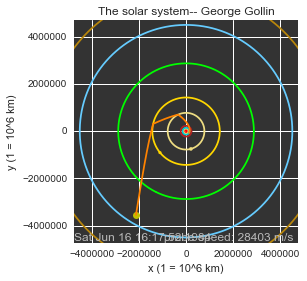

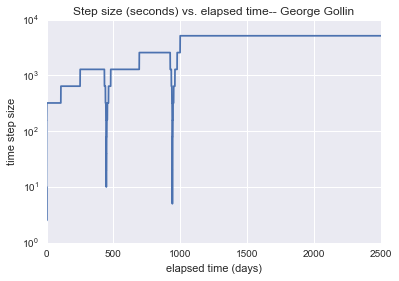

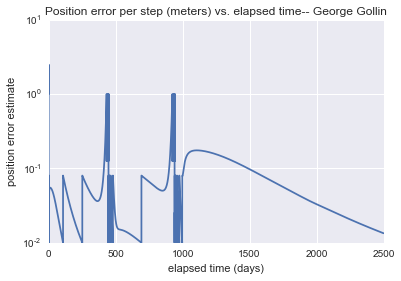

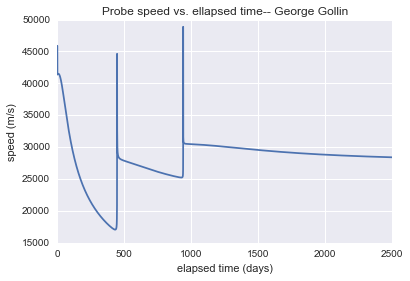

In [58]:
F(16105.6515)